# Stage 1 - Characteristic Functions Methods
If characteristic function is known then we can use effiecient methods to approximate CDF and PDF.
    
Having the corresponding PDF it allows us to price the options, i.e. computing the following integral under risk-neutral probability measure $\mathbb{Q}$:

$$ v(x, t_0) = e^{-r\Delta t} \mathbb{E}^{\mathbb{Q}}[v(y, T) \, | \, x ] = e^{-r\Delta t} \int_\mathbb{R} v(y, T) f(y \mid x) \, \mathrm{d}y  $$

## TO DO:
    1 -
    

In [1]:
%%capture
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.special as ss
from scipy.stats import norm
from scipy.integrate import trapezoid
import pandas as pd

## COS method

In [2]:
# Recovery CDF
def cos_cdf(a, b, omega, chf, x):
    # F_k coefficients
    F_k = 2.0 / (b - a) * np.real(chf * np.exp(-1j * omega * a))
    cdf = np.squeeze(F_k[0] / 2.0 * (x - a)) + np.matmul(F_k[1:] / omega[1:], np.sin(np.outer(omega[1:], x - a)))
    
    return cdf

# Recover PDF
def cos_pdf(a, b, omega, chf, x): 
    # F_k coefficients
    F_k = 2.0 / (b - a) * np.real(chf * np.exp(-1j * omega * a))
    # Separate first term and remaining terms like in cos_cdf
    pdf = F_k[0] / 2.0 + np.matmul(F_k[1:], np.cos(np.outer(omega[1:], x - a)))
    
    return pdf

def cos_pdf2(a, b, N, chf, x): # chf(omega)
    #i = np.complex(0.0, 1.0)  # assigning i=sqrt(-1)
    k = np.linspace(0, N-1, N)
    #u = np.zeros([1,N]) # Num of arguments for ch.f.
    u = k * np.pi / (b-a) # scale; frequencies -- u = omega 
    # F_k coefficients
    F_k = 2.0 / (b - a) * np.real(chf(u) * np.exp(-1j * u * a))
    F_k[0] = F_k[0] * 0.5  # first term
    # Final calculation
    pdf = np.matmul(F_k, np.cos(np.outer(u, x - a)))
    
    return pdf


Convergence table:


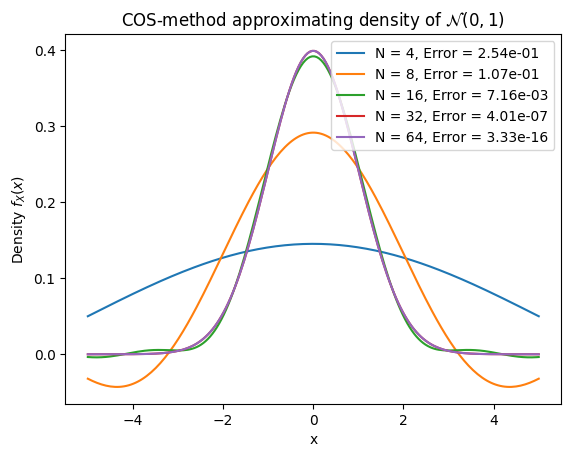

    N         Error  CPU time (msec.)  Diff. in CPU (msec.)
0   4  2.536344e-01          0.031257                   NaN
1   8  1.074376e-01          0.014210             -0.017047
2  16  7.158203e-03          0.020194              0.005984
3  32  4.008963e-07          0.034618              0.014424
4  64  3.330669e-16          0.066471              0.031853

Testing CDF recovery:


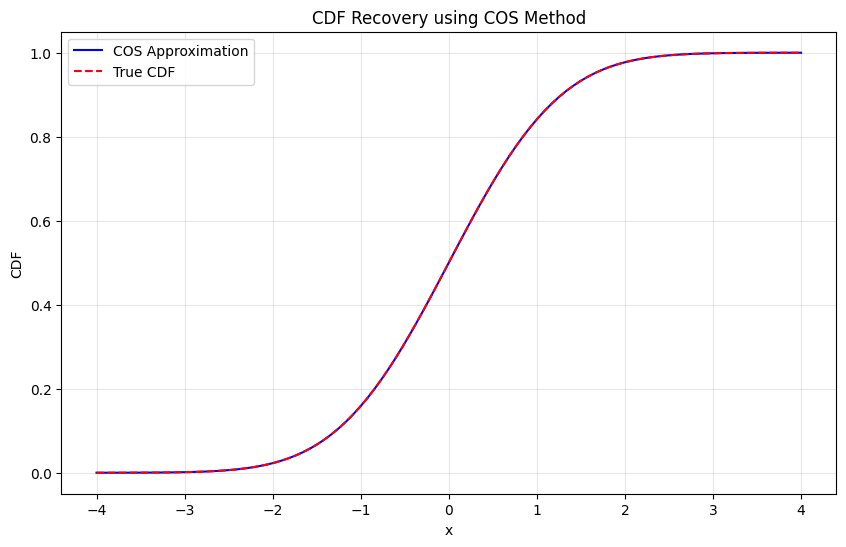

Maximum CDF error: 5.55e-16


In [3]:
# Test
def generate_cos_convergence_analysis():
    """ Make a plot & table of error convergence of COS method for approximating PDF of standard normal 
    """
    # Define characteristic function of standard normal
    def chf_normal(omega):
        return np.exp(-0.5 * omega**2)
    
    # Setup test parameters
    a, b = -10, 10                   # Domain boundaries
    x = np.linspace(-5, 5, 200)      # Points to evaluate
    exact_pdf = norm.pdf(x)          # Exact pdf to match
    N_values = [4, 8, 16, 32, 64]    # Number of terms to test
    
    # Initialise vectors
    errors = []
    cpu_times = []
    diff_cpu_times = []
        
    prev_time = 0
    
    # Test each value of N
    for N in N_values:
        # Compute frequencies (omega) for this N
        k = np.linspace(0, N-1, N)
        omega = k * np.pi / (b - a)
        
        # Pre-compute characteristic function values
        chf_values = chf_normal(omega)
        
        # Measure CPU time correctly
        times = []
        for _ in range(10):  # Run more times for more stable timing
            start = time.time()
            # Use the new cos_pdf signature with pre-computed values
            cos_pdf_values = cos_pdf(a, b, omega, chf_values, x)
            end = time.time()
            times.append((end - start) * 1000)  # Convert to milliseconds
        
        cpu_time = np.mean(times)
        
        # Calculate maximum error
        error = np.max(np.abs(cos_pdf_values - exact_pdf))
        
        # Calculate difference in CPU time
        diff_time = cpu_time - prev_time if N != 4 else 0
        
        # Store results
        errors.append(error)
        cpu_times.append(cpu_time)
        diff_cpu_times.append(diff_time if N != 4 else None)  # Set first row = None
        
        prev_time = cpu_time
    
        # Plot of the approximations
        plt.plot(x, cos_pdf_values, label=f'N = {N}, Error = {error:.2e}')
    
    plt.title("COS-method approximating density of $\mathcal{N}(0,1)$")
    plt.xlabel("x")
    plt.ylabel("Density $f_X(x)$")
    plt.legend()  
    plt.show()
    
    # Create a pandas DataFrame
    results_df = pd.DataFrame({
        'N': N_values,
        'Error': errors,
        'CPU time (msec.)': cpu_times,
        'Diff. in CPU (msec.)': diff_cpu_times
    })
    return results_df

# Test COS CDF recovery
def test_cos_cdf():
    """ Test CDF recovery for standard normal """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    x_vals = np.linspace(-4, 4, 100)
    
    # Recover CDF
    a, b, = -8.0, 8.0
    N = 2**12
    k_values = np.arange(N)
    omega = k_values * np.pi / (b - a)
    chf_values = chf_normal(omega)
    
    cdf_approx = cos_cdf(a, b, omega, chf_values, x_vals)
    
    # True CDF
    cdf_true = norm.cdf(x_vals)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, cdf_approx, 'b-', label='COS Approximation')
    plt.plot(x_vals, cdf_true, 'r--', label='True CDF')
    plt.title("CDF Recovery using COS Method")
    plt.xlabel("x")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Report error
    max_error = np.max(np.abs(cdf_approx - cdf_true))
    print(f"Maximum CDF error: {max_error:.2e}")

# Run tests
if __name__ == "__main__":    
    print("\nConvergence table:")
    print(generate_cos_convergence_analysis()) # includes the plot
    
    print("\nTesting CDF recovery:")
    test_cos_cdf()

## Carr-Madan method

In [4]:
N_values = [16, 32, 64, 128, 256, 512]

In [5]:
# Recover CDF
def carr_madan_cdf(chf, x_grid, u_max=200, N=2**12):
    """
    Recover CDF from characteristic function using Gil-Pelaez inversion formula.
    Parameters:
    - chf: function, characteristic function phi(u)
    - x_grid: np.array, evaluation points for CDF
    - u_max: upper frequency limit (increased for better tail accuracy)
    - N: number of frequency discretization points (increased for better resolution)
    Returns:
    - cdf: np.array, CDF values at x_grid
    """
    # Starting from close to 0
    u_min = 1e-10  # Much smaller starting point to capture low-frequency behavior
    u = np.linspace(u_min, u_max, N)
    
    # Compute integrand for each x (unchanged)
    integrand = np.imag(np.exp(-1j * np.outer(x_grid, u)) * chf(u)) / u  # shape: (len(x), N)
    
    # Integrate using trapezoidal rule along frequency axis (unchanged)
    integral = trapezoid(integrand, u, axis=1)
    
    # Apply Gil-Pelaez inversion formula
    cdf = 0.5 - (1 / np.pi) * integral
    
    return np.clip(np.squeeze(cdf), 0.0, 1.0)  # Clamp in [0,1]

# Recover PDF
def carr_madan_pdf(chf, x_grid, u_max=100, N=2**12):
    """
    Recover PDF using Carr-Madan method (Inverse Fourier Transform)

    Parameters:
    - chf: function, characteristic function φ(u)
    - x_grid: np.array, points where to compute the PDF
    - u_max: upper bound for frequency domain
    - N: number of discretization points (power of 2 for FFT)

    Returns:
    - pdf: np.array, PDF values at each x in x_grid
    """
    du = 2 * u_max / N
    u = np.linspace(-u_max, u_max - du, N)
    
    # Compute integrand of inverse Fourier transform
    integrand = np.exp(-1j * np.outer(x_grid, u)) * chf(u)
    
    # Numerical integration using trapezoidal rule
    integral = np.trapezoid(integrand, u, axis=1)
    
    pdf = np.squeeze(np.real(integral) / (2 * np.pi))
    return pdf



Convergence plot and table:


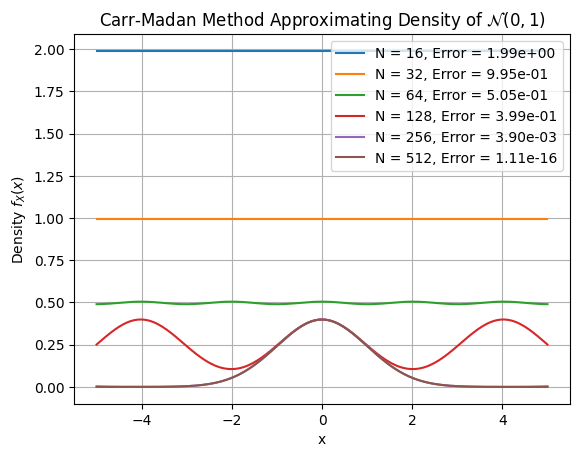

     N         Error  CPU time (msec.)  Diff. in CPU (msec.)
0   16  1.989435e+00          0.150585                   NaN
1   32  9.947169e-01          0.199223              0.048637
2   64  5.047621e-01          0.298405              0.099182
3  128  3.989628e-01          0.576210              0.277805
4  256  3.898076e-03          1.009417              0.433207
5  512  1.110223e-16          2.252769              1.243353

Testing CDF recovery:


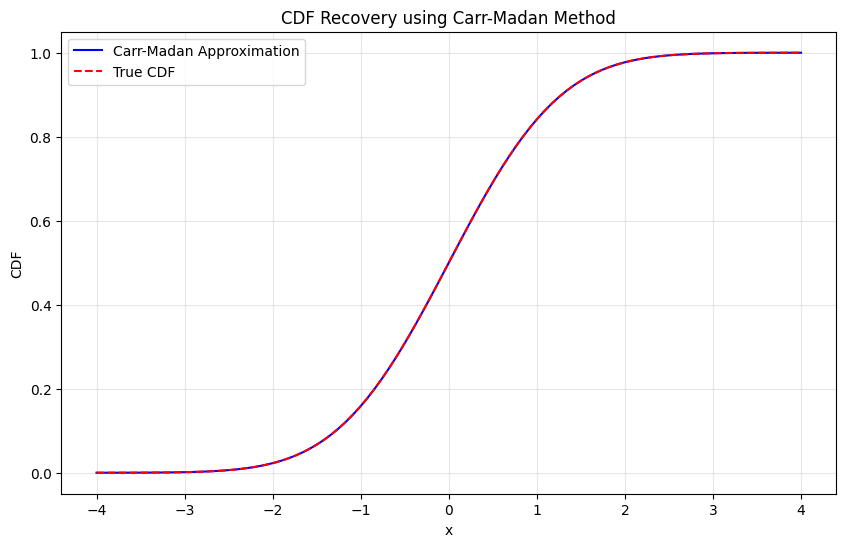

Maximum CDF error: 1.27e-10


In [6]:
# Test Carr-Madan
def generate_carr_madan_convergence_analysis():
    """ Make a plot & table of error convergence for Carr-Madan method approximating PDF of standard normal """
    def chf_normal(u):
        return np.exp(-0.5 * u**2)
    
    x = np.linspace(-5, 5, 200)
    exact_pdf = norm.pdf(x)
    #N_values = [16, 32, 64, 128, 256, 512]  # FFT sizes
    
    errors = []
    cpu_times = []
    diff_cpu_times = []
    
    prev_time = 0
    
    for N in N_values:
        times = []
        for _ in range(5):  # Run a few times for stability
            start = time.time()
            pdf_vals = carr_madan_pdf(chf_normal, x, N=N)
            end = time.time()
            times.append((end - start) * 1000)  # ms
        
        cpu_time = np.mean(times)
        error = np.max(np.abs(pdf_vals - exact_pdf))
        diff_time = cpu_time - prev_time if N != N_values[0] else 0
        
        errors.append(error)
        cpu_times.append(cpu_time)
        diff_cpu_times.append(diff_time if N != N_values[0] else None)
        
        prev_time = cpu_time
        
        # Plot
        plt.plot(x, pdf_vals, label=f'N = {N}, Error = {error:.2e}')
    
    plt.title("Carr-Madan Method Approximating Density of $\mathcal{N}(0,1)$")
    plt.xlabel("x")
    plt.ylabel("Density $f_X(x)$")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    results_df = pd.DataFrame({
        'N': N_values,
        'Error': errors,
        'CPU time (msec.)': cpu_times,
        'Diff. in CPU (msec.)': diff_cpu_times
    })
    
    return results_df

# Test Carr-Madan CDF recovery
def test_carr_madan_cdf():
    """ Test CDF recovery for standard normal """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    x_vals = np.linspace(-4, 4, 100)
    
    # Recover CDF
    cdf_approx = carr_madan_cdf(chf_normal, x_vals, N=2**12)
    
    # True CDF
    cdf_true = norm.cdf(x_vals)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, cdf_approx, 'b-', label='Carr-Madan Approximation')
    plt.plot(x_vals, cdf_true, 'r--', label='True CDF')
    plt.title("CDF Recovery using Carr-Madan Method")
    plt.xlabel("x")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Report error
    max_error = np.max(np.abs(cdf_approx - cdf_true))
    print(f"Maximum CDF error: {max_error:.2e}")
    
# Run tests
if __name__ == "__main__":    
    print("\nConvergence plot and table:")
    print(generate_carr_madan_convergence_analysis()) # includes the plot
    
    print("\nTesting CDF recovery:")
    test_carr_madan_cdf()

## CONV method

Testing PDF recovery:


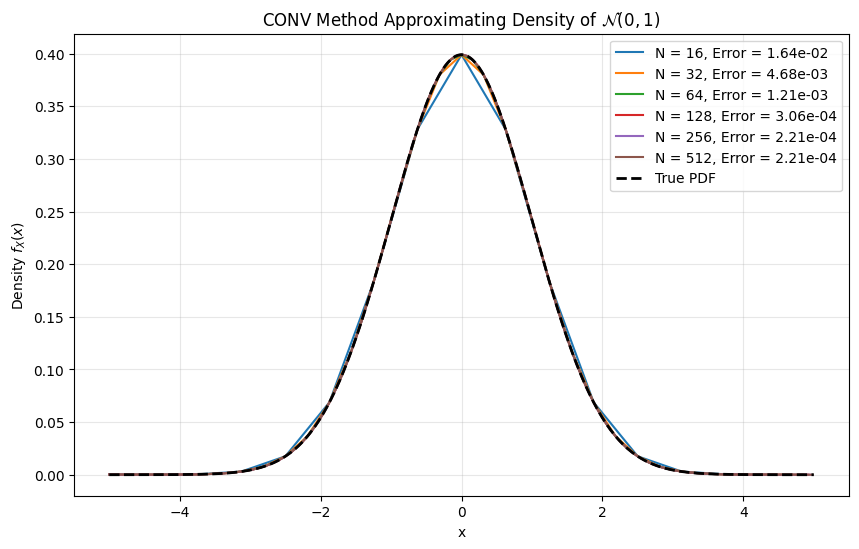


Convergence table:
     N     Error  CPU time (msec.)  Diff. in CPU (msec.)
0   16  0.016440          0.043154                   NaN
1   32  0.004682          0.033808             -0.009346
2   64  0.001210          0.034952              0.001144
3  128  0.000306          0.038624              0.003672
4  256  0.000221          0.044441              0.005817
5  512  0.000221          0.103092              0.058651

Testing CDF recovery:


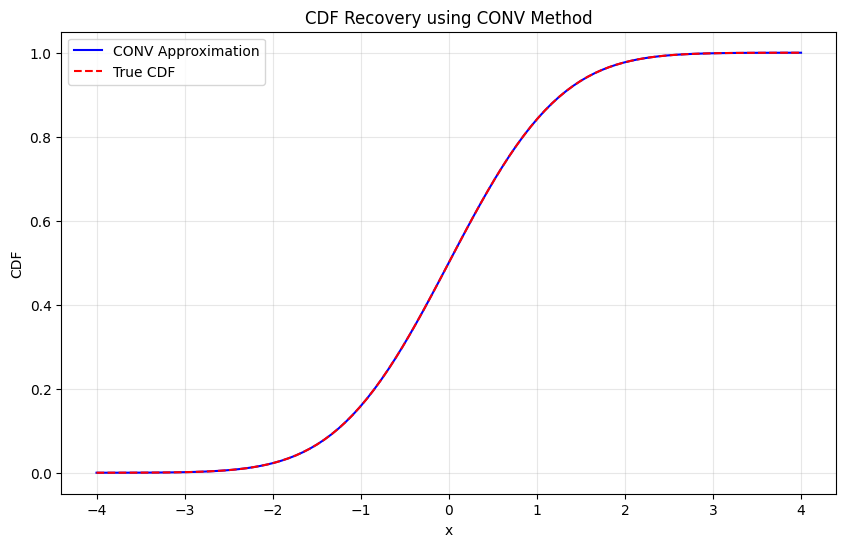

Maximum CDF error: 7.56e-07


In [7]:
def conv_pdf(chf, x_range=(-5, 5), alpha=1.0, N=2**12):
    """
    CONV method for PDF recovery using FFT
    
    This implementation carefully handles the discrete approximation of:
    f(x) = (1/2pi) \int phi(u-ia) e^{-iux} du
    
    The key insights:
    1. The FFT computes a discrete approximation to the continuous Fourier transform
    2. We must carefully align the frequency and spatial grids
    3. The damping factor 'alpha'(denote as a in comments) ensures numerical stability
    
    Parameters:
    - chf: characteristic function phi(u)
    - x_range: tuple (x_min, x_max) for the output domain
    - alpha: damping factor (positive for stability)
    - N: number of FFT points (power of 2 recommended)
    
    Returns:
    - x: real-space grid
    - pdf: corresponding recovered PDF values
    """
    
    # Step 1: Set up the grids
    x_min, x_max = x_range
    L = x_max - x_min  # Total length of spatial domain
    
    # Spatial and frequency grid spacings
    dx = L / N
    du = 2 * np.pi / L
    
    # Step 2: Create the frequency grid
    # For FFT, we need frequencies from -u_max to u_max where u_max = pi/dx
    # But FFT expects a specific ordering
    u_max = np.pi / dx  # Nyquist frequency
    
    # Create frequency array in "standard" order from -u_max to u_max
    if N % 2 == 0:
        # For even N: [-N/2, -N/2+1, ..., -1, 0, 1, ..., N/2-1] x du
        k = np.concatenate([np.arange(-N//2, 0), np.arange(0, N//2)])
    else:
        # For odd N: [-(N-1)/2, ..., -1, 0, 1, ..., (N-1)/2] x du
        k = np.arange(-(N-1)//2, (N+1)//2)
    
    u = k * du
    
    # Step 3: Create the spatial grid
    # Important: This grid corresponds to the FFT output ordering
    x = x_min + np.arange(N) * dx
    
    # Step 4: Evaluate the damped characteristic function
    # phi(u - ia) provides exponential damping for numerical stability
    phi_damped = chf(u - 1j * alpha)
    
    # Step 5: Prepare the integrand for FFT
    # We need to include a phase factor to account for the shift to x_min
    # The continuous transform of phi(u)e^{-iu x_min} gives f(x + x_min)
    integrand = phi_damped * np.exp(-1j * u * x_min)
    
    # Step 6: Apply FFT with correct ordering
    # FFT expects input in order [0, 1, ..., N/2-1, -N/2, ..., -1]
    # So we need to reorder our frequency-domain data
    integrand_fft_order = np.fft.ifftshift(integrand)
    
    # Step 7: Compute the FFT
    # This approximates the integral \int{ phi(u-ia) e^{-iu(x-x_min)} du }
    fft_result = np.fft.fft(integrand_fft_order)
    
    # Step 8: Extract and normalize the PDF
    # The factor du converts the sum to an integral
    # The factor 1/(2pi) comes from the inverse Fourier transform
    # The factor e^{-ax} removes the damping we introduced
    pdf = np.real(fft_result) * np.exp(-alpha * x) * du / (2 * np.pi)
    
    # Step 9: Ensure non-negativity (small numerical errors can cause negative values)
    pdf = np.maximum(pdf, 0)
    
    # Check: Normalize to ensure integral equals 1
    integral = trapezoid(pdf, x)
    if integral > 0:
        pdf = pdf / integral
    
    return x, pdf

def conv_cdf(chf, x_vals, x_range=None, alpha=0.5, N=2**13):
    """
    Recover CDF directly from characteristic function by integrating the recovered PDF.
    
    This approach:
    1. Uses conv_pdf() to recover the PDF from the characteristic function
    2. Numerically integrates the PDF to get the CDF
    
    Parameters:
    - chf: characteristic function φ(u)
    - x_vals: array of x values where we want to evaluate the CDF
    - x_range: tuple (x_min, x_max) for PDF recovery domain
               If None, automatically determined from x_vals with padding
    - alpha: damping factor for PDF recovery (default 0.5)
    - N: number of FFT points for PDF recovery (default 2^13)
    
    Returns:
    - cdf_vals: CDF values at the requested x_vals points
    """
    
    # Step 1: Determine the domain for PDF recovery
    if x_range is None:
        # Automatically choose a domain that covers x_vals with some padding
        # This ensures we capture the full probability mass
        x_min_req = np.min(x_vals)
        x_max_req = np.max(x_vals)
        padding = (x_max_req - x_min_req) * 0.5  # 50% padding on each side
        x_range = (x_min_req - padding, x_max_req + padding)
    
    # Step 2: Recover the PDF using our existing function
    x_grid, pdf_grid = conv_pdf(chf=chf, x_range=x_range, alpha=alpha, N=N)
    
    # Step 3: Compute CDF on the native grid by cumulative integration
    # Using the trapezoidal rule for integration
    dx = x_grid[1] - x_grid[0]  # Grid spacing (uniform)
    cdf_grid = np.zeros_like(pdf_grid)
    
    # Integrate from left to right: CDF[i] = \int_{-\infty}^{x[i]} PDF(t) dt
    cdf_grid[0] = 0.0  # CDF starts at 0 at the leftmost point
    for i in range(1, len(cdf_grid)):
        # Add the area of the trapezoid between points i-1 and i
        cdf_grid[i] = cdf_grid[i-1] + 0.5 * (pdf_grid[i-1] + pdf_grid[i]) * dx
    
    # Alternative vectorized approach (more efficient):
    # cdf_grid = np.concatenate([[0], np.cumsum(0.5 * (pdf_grid[:-1] + pdf_grid[1:]) * dx)])
    
    # Step 4: Interpolate CDF to the requested x_vals
    cdf_vals = np.interp(x_vals, x_grid, cdf_grid)
    
    # Step 5: Ensure CDF properties are satisfied
    # CDF should be between 0 and 1, and monotonically increasing
    cdf_vals = np.clip(cdf_vals, 0.0, 1.0)
    
    return cdf_vals

def conv_cdf_GP(chf, x_vals, u_max=100, N=2**13):
    """ Recover CDF using Gil-Pelaez inversion formula
        CDF(x) = 1/2 - (1/pi) \int_0^\infty Im[e^(-iux)phi(u)]/u du """
    # Use positive u only (integrand is odd in u)
    du = u_max / N
    u = np.linspace(du, u_max, N)  # avoid u=0 singularity
    
    # Vectorized computation for all x values
    integrand = np.imag(np.exp(-1j * np.outer(x_vals, u)) * chf(u)) / u
    
    # Integrate over u for each x
    integral = trapezoid(integrand, u, axis=1)
    
    # Apply inversion formula
    cdf = 0.5 - (1 / np.pi) * integral
    
    return np.clip(cdf, 0.0, 1.0)


# Test functions
def plot_conv_pdf_convergence():
    """ Test PDF recovery with standard normal distribution """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    x_true = np.linspace(-5, 5, 500)
    true_pdf = norm.pdf(x_true)
    
    #N_values = [64, 128, 256, 512, 1024, 2048]
    #N_values = [16, 32, 64, 128, 256, 512]
    #N_values = [4, 8, 16, 32, 64]
    
    plt.figure(figsize=(10, 6))
    
    # Store errors for the table
    results = []
    
    for N in N_values:
        # Use fixed domain and moderate damping
        x, pdf = conv_pdf(chf=chf_normal, x_range=(-5, 5), alpha=0.5, N=N)
        
        # Interpolate to common grid for comparison
        interp_pdf = np.interp(x_true, x, pdf)
        error = np.max(np.abs(interp_pdf - true_pdf))
        
        plt.plot(x, pdf, label=f'N = {N}, Error = {error:.2e}')
        results.append((N, error))
    
    plt.plot(x_true, true_pdf, 'k--', linewidth=2, label='True PDF')
    plt.title("CONV Method Approximating Density of $\mathcal{N}(0,1)$")
    plt.xlabel("x")
    plt.ylabel("Density $f_X(x)$")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results

def generate_conv_convergence_table():
    """ Generate convergence table with timings """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    # Create a common reference grid for fair comparison
    x_true = np.linspace(-5, 5, 500)
    true_pdf = norm.pdf(x_true)
    
    errors = []
    cpu_times = []
    diff_cpu_times = []
    prev_time = 0
    
    for N in N_values:
        # Time multiple runs for accuracy
        times = []
        for _ in range(10):
            start = time.time()
            x, pdf = conv_pdf(chf=chf_normal, x_range=(-5, 5), alpha=0.5, N=N)
            end = time.time()
            times.append((end - start) * 1000)
        
        avg_time = np.mean(times)
        
        # FIXED: Interpolate to common grid before computing error
        interp_pdf = np.interp(x_true, x, pdf)
        error = np.max(np.abs(interp_pdf - true_pdf))
        
        # Time difference
        delta_time = avg_time - prev_time if N != N_values[0] else None
        
        errors.append(error)
        cpu_times.append(avg_time)
        diff_cpu_times.append(delta_time)
        prev_time = avg_time
    
    table = pd.DataFrame({
        'N': N_values,
        'Error': errors,
        'CPU time (msec.)': cpu_times,
        'Diff. in CPU (msec.)': diff_cpu_times
    })
    
    return table

# Test CDF recovery
def test_conv_cdf():
    """ Test CDF recovery for standard normal 
    TO DO: Add different Ns """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    x_vals = np.linspace(-4, 4, 100)
    
    # Recover CDF
    cdf_approx = conv_cdf(chf_normal, x_vals, alpha=0.5, N=2**12)
    
    # True CDF
    cdf_true = norm.cdf(x_vals)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, cdf_approx, 'b-', label='CONV Approximation')
    plt.plot(x_vals, cdf_true, 'r--', label='True CDF')
    plt.title("CDF Recovery using CONV Method")
    plt.xlabel("x")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Report error
    max_error = np.max(np.abs(cdf_approx - cdf_true))
    print(f"Maximum CDF error: {max_error:.2e}")


# Run tests
if __name__ == "__main__":
    print("Testing PDF recovery:")
    plot_conv_pdf_convergence()
    
    print("\nConvergence table:")
    print(generate_conv_convergence_table())
    
    print("\nTesting CDF recovery:")
    test_conv_cdf()

In [8]:
def summary_convergence_table():
    """ Generate convergence table with timings """
    def chf_normal(u): 
        return np.exp(-0.5 * u**2)
    
    # Create a common reference grid for fair comparison
    x_true = np.linspace(-5, 5, 500)
    true_pdf = norm.pdf(x_true)
    
    errors = []
    cpu_times = []
    diff_cpu_times = []
    prev_time = 0
    
    for N in N_values:
        # Time multiple runs for accuracy
        times = []
        for _ in range(10):
            start = time.time()
            # Add COS
            
            # Add C-M
            x, pdf = conv_pdf(chf=chf_normal, x_range=(-5, 5), alpha=0.5, N=N)
            end = time.time()
            times.append((end - start) * 1000)
        
        avg_time = np.mean(times)
        
        # FIXED: Interpolate to common grid before computing error
        interp_pdf = np.interp(x_true, x, pdf)
        error = np.max(np.abs(interp_pdf - true_pdf))
        
        # Time difference
        delta_time = avg_time - prev_time if N != N_values[0] else None
        
        errors.append(error)
        cpu_times.append(avg_time)
        diff_cpu_times.append(delta_time)
        prev_time = avg_time
    
    table = pd.DataFrame({
        'N': N_values,
        'Error': errors,
        'CPU time (msec.)': cpu_times,
        'Diff. in CPU (msec.)': diff_cpu_times
    })
    
    return table

In [9]:
# Just stacking those three tables on top of eachother

# Put Ch.f. methods into one table over common N-number
